<a href="https://colab.research.google.com/github/LeilaelRico/TC3002B_M2/blob/augEx/A01707023__Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto
Cristian Leilael Rico Espinosa

Matrícula: A01707023

Proyecto para el Módulo 2 de "Desarrollo de aplicaciones avanzadas de ciencias computacionales". En este se realizará un modelo el cual se entrenará con imágenes de paisajes para que, posteriormente, pueda identificar imágenes pertenecientes a estos.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/TC3002B_M2"
!ls

/content/drive/MyDrive/TC3002B_M2
images


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

## Preprocesado de Datos

Se comienza con la carga y preprocesamiento de imágenes desde directorios, escalando sus valores de píxeles al rango de 0 a 1 para, posteriormente, crear generadores de datos los cuales serán utilizados durante el entrenamiento y la prueba del modelo.

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							)

test_generator = train_datagen.flow_from_directory(
							test_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							)

Found 8400 images belonging to 5 classes.
Found 2100 images belonging to 5 classes.


### Imágenes de *Train*

Para comprobar si la conversión se hizo adecuadamente, se utiliza *plot* para mostrar visualizaciones de algunas de las imágenes.

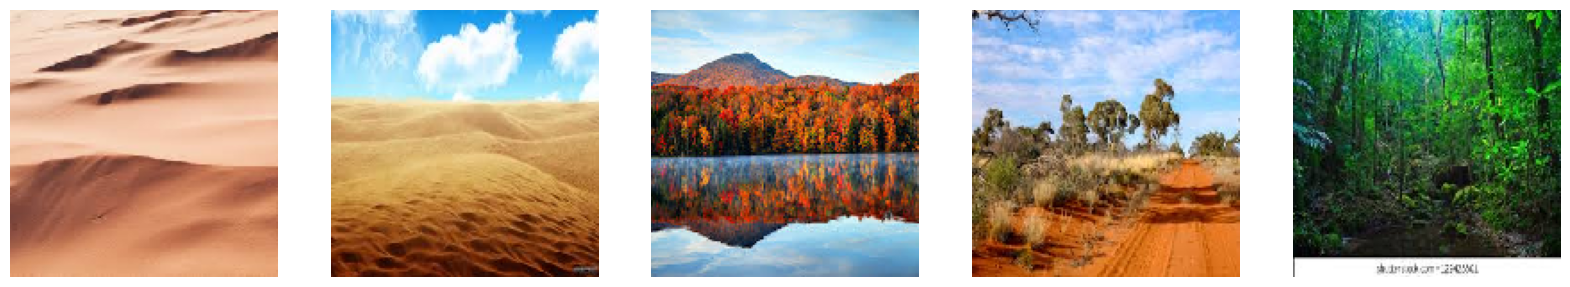

In [5]:
plt.figure(figsize=(20, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    batch = train_generator.next()
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Imágenes de *Test*

Para comprobar si la conversión se hizo adecuadamente, se utiliza *plot* para mostrar visualizaciones de algunas de las imágenes.

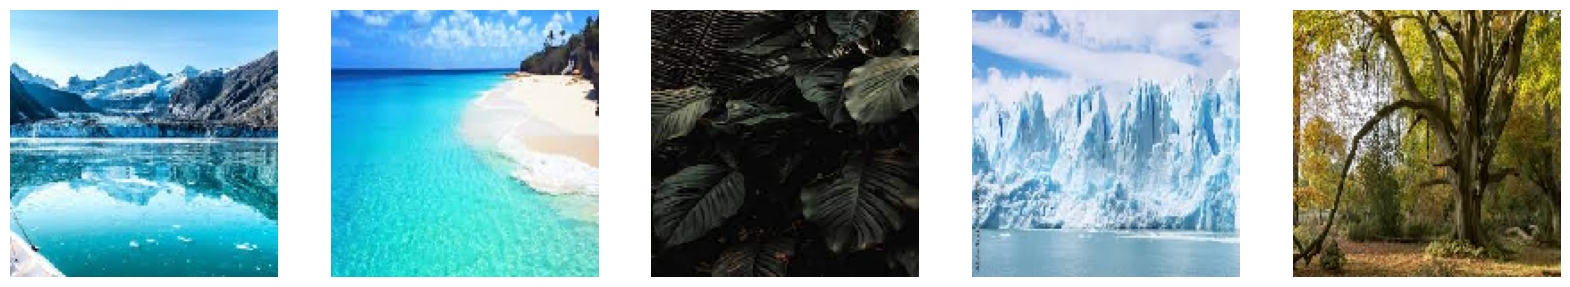

In [6]:
plt.figure(figsize=(20, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    batch = test_generator.next()
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
plt.show()